<a href="https://colab.research.google.com/github/jharris121/AcademyPublic/blob/main/Session5%20-%20Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Session 3 - Data Visulisation

!pip install -q kaggle
from google.colab import files
files.upload()
#create a kaggle folder
!mkdir ~/.kaggle
# Go on kaggle > Account > Create New API token
# Save the json file in your laptop in a dedicated folder
# copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json
# Datasets available here: 
# https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009
!unzip red-wine-quality-cortez-et-al-2009.zip

import pandas as pd # Here I import a library named pandas which is specialized in
# data manipulation. I give an alias pd it is a kind of pseudonyme where pd refers to pandas.
import numpy as np
df = pd.read_csv('/content/winequality-red.csv')


Saving kaggle.json to kaggle.json
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 22.5MB/s]
Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: winequality-red.csv     


In [2]:
# Now let's complexify the database in order to have additional work to do later! Not important to understand
# Educational purpose

# Here I create a binary feature who will be used as target
# We use the numpy.where function which is equivalent to a if-then-else statement
# If df['quality'] >= 7 then df['Y']=1, else df['Y']=0
df['Y'] = np.where(df['quality']>= 7, 1, 0)

# We create as well some binary features of 'fixed acidity' & 'volatile acidity'
df['fixed_acidity_cat'] = np.where(df['fixed acidity']<= 8, 0, 1)
df['volatile_acidity_cat'] = np.where(df['volatile acidity']>= 0.4, 0, 1)

# Here I create some duplicates rows: I do a random sample of df and then I concat them at the end of df
temp = df.sample(n=150, random_state=893717398)
df = df.append(temp)
del(temp)
df.reset_index(drop=True, inplace=True)

# Here I create a new feature pH2 from pH where I had some missing values
df['pH2'] = np.where(df['pH'].index %15 ==0, np.nan, df['pH'])

# Here I create a new random feature 'acidity_other' from 'fixed acidity' and I create some missing values
rng = np.random.default_rng(893717398)
df = df.join(pd.Series(rng.normal(df['fixed acidity'].median(),1,len(df)), name='acidity_other'))
df['acidity_other'] = np.where(df['acidity_other'].index %2 !=0, np.nan, df['pH'])

#Here it is a function that will automatically create a feature of random dates between a defined interval
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds 
    (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to 
    the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by 
    the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit)

# Now I apply my function in order to create the new feature 'date'
np.random.seed(893717398)
d_start = pd.to_datetime('2021-01-01')
d_end = pd.to_datetime('2021-06-30')
df['date'] = random_datetimes_or_dates(d_start, d_end, out_format='datetime', n=len(df))
df['date'] = df['date'].astype(str)

## End of the complexification



In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Y,fixed_acidity_cat,volatile_acidity_cat,pH2,acidity_other,date
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0,0,NaN,3.51,2021-01-06 14:38:36
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,0,0,3.20,NaN,2021-02-07 08:11:30
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,0,0,3.26,3.26,2021-06-27 12:25:26
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,1,1,3.16,NaN,2021-06-16 05:25:38
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0,0,3.51,3.51,2021-01-20 10:10:16


In [4]:
df.shape

(1749, 18)

In [5]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Y                         int64
fixed_acidity_cat         int64
volatile_acidity_cat      int64
pH2                     float64
acidity_other           float64
date                     object
dtype: object

In [6]:
def citric_acid_cat(x):
  if x < 0.21 :
    return 'A'
  elif x < 0.3 :
    return 'B'
  else:
    return 'C'

# Now we want to create a new feature citric_cat, which transform the numerical value
# of citric acid to the category defined above for each line of the feature.
# We could create a for loop. However the apply lambda is more efficient from a computing point of view 
# The x refers to the x of the function which is df['citric acid']
df['citric_cat'] = df['citric acid'].apply(lambda x: citric_acid_cat(x))


In [7]:
df['citric_cat'].describe()

count     1749
unique       3
top          C
freq       773
Name: citric_cat, dtype: object

In [8]:
df['citric_cat']=np.where(df['citric_cat'] == 'C', 'Z', df['citric_cat'])

In [9]:
df['citric_cat'].value_counts()

Z    773
A    693
B    283
Name: citric_cat, dtype: int64

In [10]:
np.round(df['citric_cat'].value_counts(True)*100,2)

Z    44.20
A    39.62
B    16.18
Name: citric_cat, dtype: float64

In [11]:
df.isna().sum(1)

0       1
1       1
2       0
3       1
4       0
       ..
1744    0
1745    1
1746    0
1747    1
1748    0
Length: 1749, dtype: int64

In [12]:
df['date'].head(3)
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

In [13]:
df.dtypes

fixed acidity                  float64
volatile acidity               float64
citric acid                    float64
residual sugar                 float64
chlorides                      float64
free sulfur dioxide            float64
total sulfur dioxide           float64
density                        float64
pH                             float64
sulphates                      float64
alcohol                        float64
quality                          int64
Y                                int64
fixed_acidity_cat                int64
volatile_acidity_cat             int64
pH2                            float64
acidity_other                  float64
date                    datetime64[ns]
citric_cat                      object
dtype: object

In [14]:
today = pd.to_datetime('2021-10-12', format = '%Y-%m-%d')
today
df['time_diff'] = today -df['date']
df['time_diff'].head(3)

0   278 days 09:21:24
1   246 days 15:48:30
2   106 days 11:34:34
Name: time_diff, dtype: timedelta64[ns]

In [15]:
df.dtypes

fixed acidity                   float64
volatile acidity                float64
citric acid                     float64
residual sugar                  float64
chlorides                       float64
free sulfur dioxide             float64
total sulfur dioxide            float64
density                         float64
pH                              float64
sulphates                       float64
alcohol                         float64
quality                           int64
Y                                 int64
fixed_acidity_cat                 int64
volatile_acidity_cat              int64
pH2                             float64
acidity_other                   float64
date                     datetime64[ns]
citric_cat                       object
time_diff               timedelta64[ns]
dtype: object

In [16]:
df['day_diff']=(df['time_diff']/np.timedelta64(1, 'D')).astype(float)
df['day_diff']

0       278.389861
1       246.658681
2       106.482338
3       117.773866
4       264.576204
           ...    
1744    229.515891
1745    122.306586
1746    130.300637
1747    223.381343
1748    205.710289
Name: day_diff, Length: 1749, dtype: float64

In [17]:
##### Worked up to here then lost track 

# Now let's pratice some merges
# First, let's create a new database randomf1 & randomf2:
np.random.seed(893717398)
randomf1 = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
randomf2 = pd.Series(np.random.normal(1, 0.5, len(df)), name='Random_Normal_feature2')




In [18]:
# First way to do a merge: Doing a concatenation
# Be careful because it has some limitation!!!!
# You need to be sure at 100% that each rows of the 2 database to concat are referring to the same observation!!
randomf = pd.concat([randomf1, randomf2], axis=1, ignore_index=True)
randomf.columns = ['Random_Normal_feature1', 'Random_Normal_feature2']

In [19]:
# Here I create a a new feature in df that will be used as key:
np.random.seed(893717398)
df['Random_Normal_feature1'] = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')

In [20]:
# Second way to do a merge: Using the merge function:
df = df.merge(randomf, how='inner', on='Random_Normal_feature1')

In [21]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Y,fixed_acidity_cat,volatile_acidity_cat,pH2,acidity_other,time_diff,day_diff,Random_Normal_feature1,Random_Normal_feature2
count,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1632.000000,875.000000,1749,1749.000000,1749.000000,1749.000000
mean,8.313836,0.528333,0.270720,2.530389,0.087374,15.849057,46.472556,0.996750,3.310217,0.656724,10.416057,5.633505,0.134362,0.460835,0.255003,3.310692,3.305063,194 days 09:09:51.905088644,194.381851,-0.017735,0.985801
std,1.749545,0.179263,0.194979,1.386269,0.046322,10.429510,33.063597,0.001885,0.153670,0.170266,1.057782,0.806182,0.341139,0.498606,0.435987,0.153699,0.151755,51 days 14:05:30.631283353,51.587160,1.013533,0.510386
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000,0.000000,0.000000,2.740000,2.860000,104 days 02:32:47,104.106100,-3.479021,-0.460310
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000,0.000000,0.000000,3.210000,3.210000,148 days 10:20:43,148.431053,-0.672045,0.638582
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996720,3.310000,0.620000,10.200000,6.000000,0.000000,0.000000,0.000000,3.310000,3.310000,195 days 04:21:38,195.181690,-0.039044,0.984422
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997830,3.400000,0.730000,11.100000,6.000000,0.000000,1.000000,1.000000,3.400000,3.390000,238 days 14:34:35,238.607350,0.642917,1.342125
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000,1.000000,1.000000,4.010000,4.010000,283 days 20:32:55,283.856192,4.384975,2.774481


In [22]:
# We can easily do some agregations of features through a groupby:
df.groupby('citric_cat')['quality'].mean()
df.groupby(['citric_cat', 'quality'])[['sulphates', 'fixed acidity']].mean()

sulphates  fixed acidity
citric_cat quality                          
A          3         0.520000       7.314286
           4         0.558684       7.076316
           5         0.575152       7.321646
           6         0.634432       7.208791
           7         0.705000       6.679545
           8         0.793333       6.300000
B          4         0.528750       8.362500
           5         0.615679       7.991975
           6         0.680467       7.885047
           7         0.582000       6.860000
           8         0.740000       5.000000
Z          3         0.672500      10.700000
           4         0.703846       9.569231
           5         0.675591       9.347244
           6         0.709063       9.430937
           7         0.755090       9.550299
           8         0.774667       9.313333

In [23]:
# Last element very useful in data manipulation is the pivot table:
pd.pivot_table(df, values='sulphates', index=['Y', 'quality'],
                    columns=['citric_cat'], aggfunc=np.mean)

citric_cat         A         B         Z
Y quality                               
0 3         0.520000       NaN  0.672500
  4         0.558684  0.528750  0.703846
  5         0.575152  0.615679  0.675591
  6         0.634432  0.680467  0.709063
1 7         0.705000  0.582000  0.755090
  8         0.793333  0.740000  0.774667

In [24]:
# Let's import new packages:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns

In [25]:
# Bar plot
# Let's represent visually the median wine quality by citric_cat
# First: represent the database:
df_barplot = pd.DataFrame(df.groupby('citric_cat')['quality'].median()).reset_index() # Citric_cat
# is an ordered feature, so we will not change the order in the plot
df_barplot

,citric_cat,quality
0,A,5
1,B,5
2,Z,6


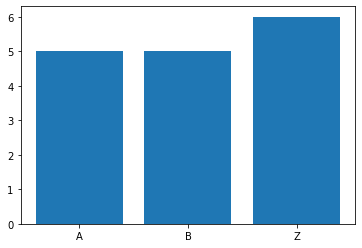

In [26]:
# We need to define a figure and a Axes:
fig1, ax = plt.subplots() # It always starts like this
# Define the kind of visualization you want, here it's a bar plot
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
plt.show()

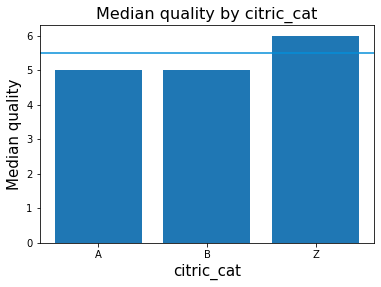

In [27]:
# Let's add a horizontal line showing the median -0.5 quality off all wines
med_quality = df['quality'].median() - 0.5
fig1, ax = plt.subplots()
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax.axhline(y=med_quality, color='#058ED9')
ax.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax.set_ylabel('Median quality', fontsize = 15)
ax.set_xlabel('citric_cat', fontsize=15)
plt.show()

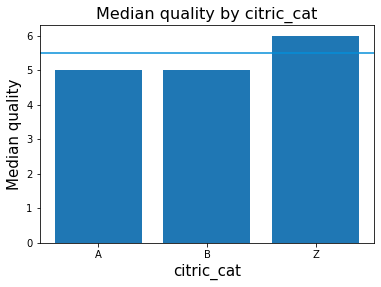

In [28]:
# Let's make the plot pretty:
med_quality = df['quality'].median() - 0.5

fig1, ax = plt.subplots()
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax.axhline(y=med_quality, color='#058ED9')

ax.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax.set_ylabel('Median quality', fontsize = 15)
ax.set_xlabel('citric_cat', fontsize=15)
plt.show()

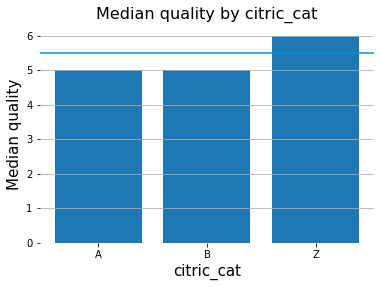

In [29]:
fig1, ax = plt.subplots()
ax.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax.axhline(y=med_quality, color='#058ED9')

ax.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax.set_ylabel('Median quality', fontsize = 15)
ax.set_xlabel('citric_cat', fontsize=15)

# Add a grid composed only by the y axis
ax.grid(b=True, which='major', axis='y')

# Delete useless visual lines:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

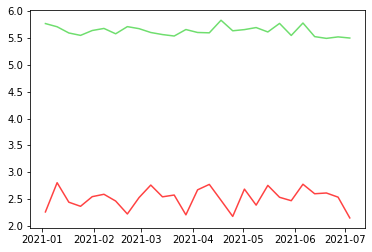

In [30]:
# Line plot: let's represent the evolution of the average quality and the average residual
# sugar per week:

df_lineplot = df[['date', 'quality', 'residual sugar']].sort_values(by='date')
df_lineplot=df_lineplot.set_index('date').resample('W').mean().reset_index()

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')
plt.show()

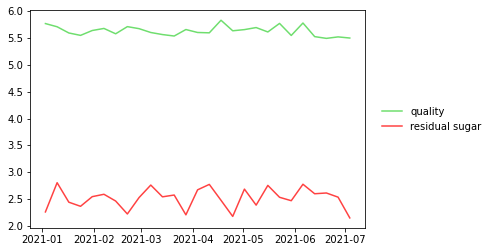

In [31]:
# With a legend

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

# Add a legend:
ax.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)

plt.show()


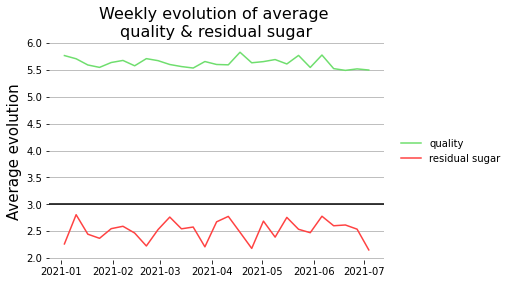

In [32]:
# Make it pretty

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

ax.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)
ax.set_title('Weekly evolution of average \nquality & residual sugar', loc='center', fontsize=16)
ax.set_ylabel('Average evolution', fontsize=15)

ax.grid(b=True, which='major', axis='y')
ax.axhline(3, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

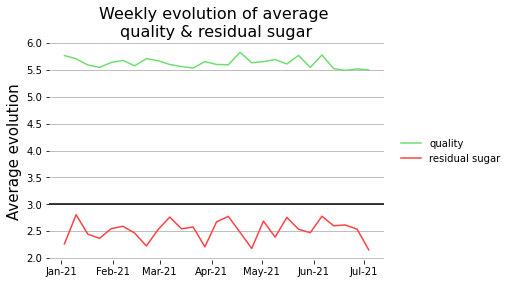

In [33]:
# Change date display
months=mdates.MonthLocator()
x_display = mdates.DateFormatter('%b-%y')

fig2, ax = plt.subplots()
ax.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

ax.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)
ax.set_title('Weekly evolution of average \nquality & residual sugar', loc='center', fontsize=16)
ax.set_ylabel('Average evolution', fontsize=15)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(x_display)

ax.grid(b=True, which='major', axis='y')
ax.axhline(3, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


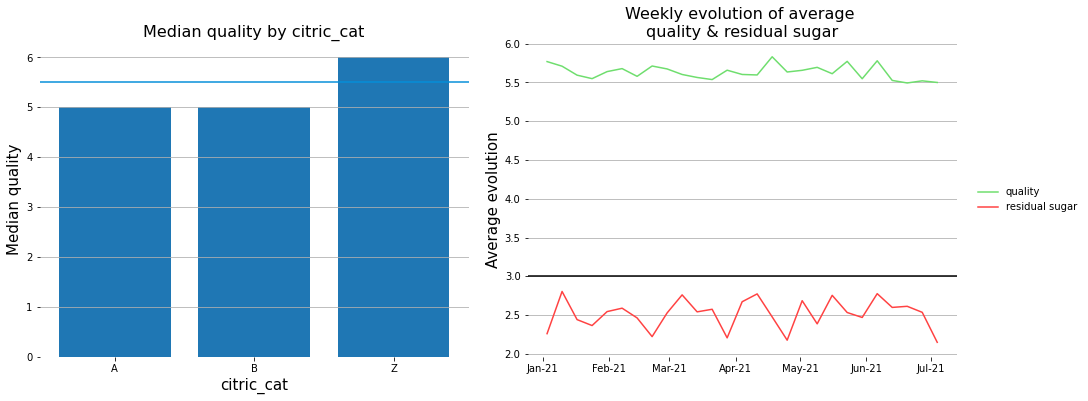

In [34]:

# Now let's try to put to plots on the same figure
# You will see the utility of Axes
med_quality = df['quality'].median() - 0.5
months=mdates.MonthLocator()
x_display = mdates.DateFormatter('%b-%y')

fig3 = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig3.add_gridspec(2,2)
ax1 = fig3.add_subplot(gs[0,0])
ax2 = fig3.add_subplot(gs[0,1])

ax1.bar(x= df_barplot['citric_cat'], height=df_barplot['quality'])
ax1.axhline(y=med_quality, color='#058ED9')

ax1.set_title('Median quality by citric_cat', loc='center', fontsize=16)
ax1.set_ylabel('Median quality', fontsize = 15)
ax1.set_xlabel('citric_cat', fontsize=15)

# Add a grid composed only by the y axis
ax1.grid(b=True, which='major', axis='y')

# Delete useless visual lines:
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


ax2.plot(df_lineplot.date, df_lineplot['quality'], color='#6FDE6E', label='quality')
ax2.plot(df_lineplot.date, df_lineplot['residual sugar'], color='#FF4242', label='residual sugar')

ax2.legend(loc='center left', bbox_to_anchor=(1.04,0.5), ncol=1, borderaxespad=0, frameon=False)
ax2.set_title('Weekly evolution of average \nquality & residual sugar', loc='center', fontsize=16)
ax2.set_ylabel('Average evolution', fontsize=15)

ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(x_display)

ax2.grid(b=True, which='major', axis='y')
ax2.axhline(3, color='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.show()

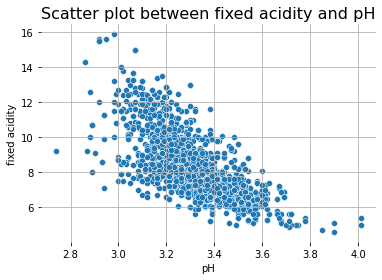

In [35]:
# You can use as well seaborn who have built-in plots
# The syntax is simplier and this is a layer of matplotlib
# which means that you can insert seaborn code in a matplotlib figure!!
fig4, ax =plt.subplots()
ax = sns.scatterplot(data=df, x="pH", y="fixed acidity")
ax.set_title('Scatter plot between fixed acidity and pH', loc='center', fontsize = 16)
ax.grid(b=True, which= 'major', axis='both')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


In [36]:
# Data Cleansing for modelling
# Here is a sumup of all the manipulation we did in order to load the dataset 
# and to add some complexity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import scipy.stats as ss
from imblearn.over_sampling import SMOTE

def citric_acid_cat(x):
  if x < 0.21 :
    return 'A'
  elif x < 0.3 :
    return 'B'
  else:
    return 'C'

df = pd.read_csv('/content/winequality-red.csv')
df['citric_cat'] = df['citric acid'].apply(lambda x: citric_acid_cat(x))
df['Y'] = np.where(df['quality']>= 7, 1, 0)
df['fixed_acidity_cat'] = np.where(df['fixed acidity']<= 8, 0, 1)
df['volatile_acidity_cat'] = np.where(df['volatile acidity']>= 0.4, 0, 1)
temp = df.sample(n=150, random_state=893717398)
df = df.append(temp)
del(temp)
df.reset_index(drop=True, inplace=True)
df['pH2'] = np.where(df['pH'].index %15 ==0, np.nan, df['pH'])
rng = np.random.default_rng(893717398)
df = df.join(pd.Series(rng.normal(df['fixed acidity'].median(),1,len(df)), name='acidity_other'))
df['acidity_other'] = np.where(df['acidity_other'].index %2 !=0, np.nan, df['pH'])
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds 
    (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to 
    the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by 
    the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit)
np.random.seed(893717398)
d_start = pd.to_datetime('2021-01-01')
d_end = pd.to_datetime('2021-06-30')
df['date'] = random_datetimes_or_dates(d_start, d_end, out_format='datetime', n=len(df))
df['date'] = df['date'].astype(str)
df['citric_cat'] = np.where(df['citric_cat'] == 'C', 'Z', df['citric_cat'])
df['date'] = pd.to_datetime(df['date'], format= '%Y-%m-%d %H:%M:%S') 
today = pd.to_datetime('2021-10-12', format = '%Y-%m-%d')
df['time_diff'] = today - df['date']
df['day_diff'] = (df['time_diff']/np.timedelta64(1, 'D')).astype(float)
np.random.seed(893717398)
randomf1 = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
randomf2 = pd.Series(np.random.normal(1, 0.5, len(df)), name='Random_Normal_feature2')
randomf = pd.concat([randomf1, randomf2], axis=1, ignore_index=True)
randomf.columns = ['Random_Normal_feature1', 'Random_Normal_feature2']
np.random.seed(893717398)
df['Random_Normal_feature1'] = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
df = df.merge(randomf, how='inner', on='Random_Normal_feature1')


In [37]:
# First of all, we need to split the data base into 3 parts:
# - One for the training part
# - One for the validation part
# - One for the temporal validation part (OOT: Out Of Time)

# Let's do the first temporal split:
# We already parsed our date feature previously (you can check with dtypes)
# Let's see the monthly number of observation
df.set_index('date').resample('M').size()

date
2021-01-31    303
2021-02-28    284
2021-03-31    297
2021-04-30    292
2021-05-31    302
2021-06-30    271
Freq: M, dtype: int64

In [39]:
# We will use the 2 last months for the OOT validation
oot = df[df['date'] >= '2021-05-01']

In [40]:
oot.date.min()


Timestamp('2021-05-01 06:06:34')

In [42]:
# Now we will keep the database without the oot:
df = df[df['date'] < '2021-05-01']
# And we will randomly split this data base in 2, one for the train and the other for the test
# As you notice we will have to validation database.
# One based on the same distribution as the train and the other from another distribution

# The random split is used with the sklean library, I decided to have 75% in train and 25% in test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=893717398)

In [43]:
# Let's see if we have duplicated rows:
feature_analyze_duplicates = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'citric_cat',
       'fixed_acidity_cat', 'volatile_acidity_cat', 'pH2', 'acidity_other']

len(train[train.duplicated(subset = feature_analyze_duplicates, keep=False)])

104

In [44]:
# We see that we have 104 rows that are duplicated, we can decide to keep the first or last.
# Let's create a function that will automatize this process

def drop_duplicate_keep_first(database, list_of_features):
  database = database.drop_duplicates(subset= list_of_features, keep='first')
  return database

train = drop_duplicate_keep_first(train, feature_analyze_duplicates)

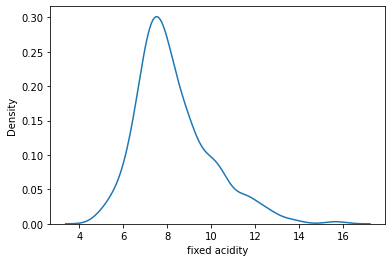

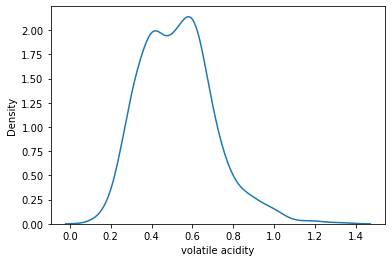

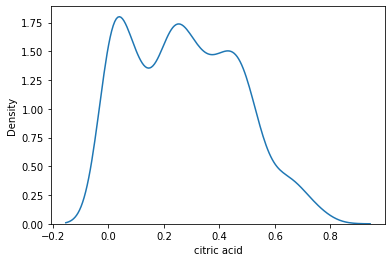

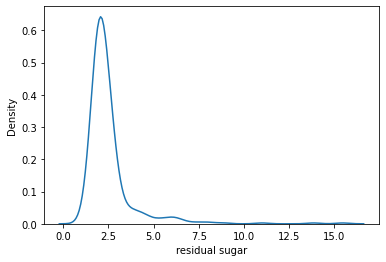

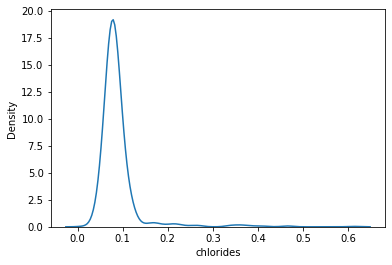

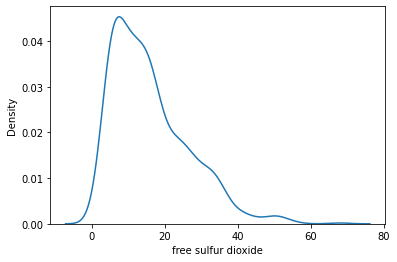

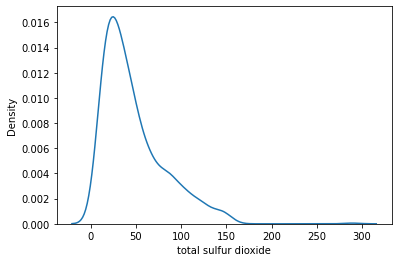

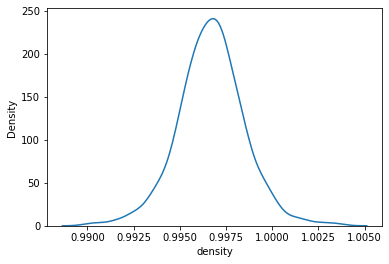

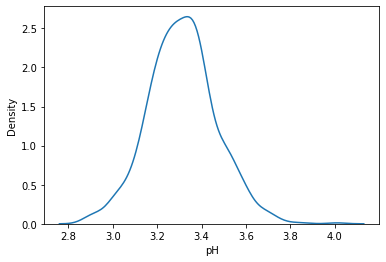

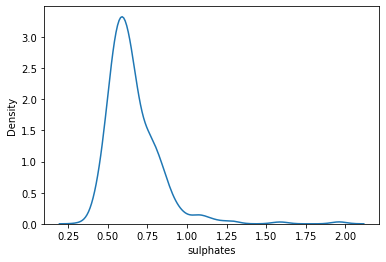

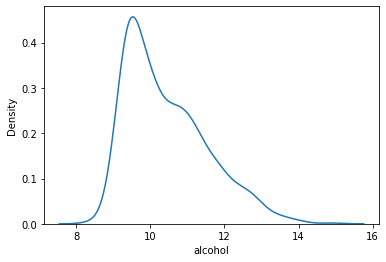

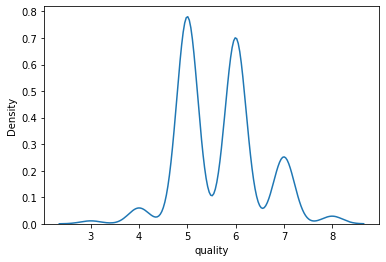

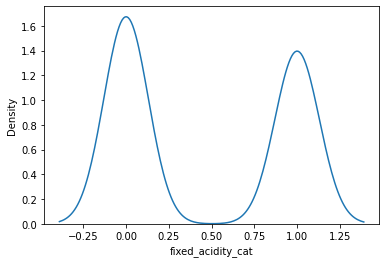

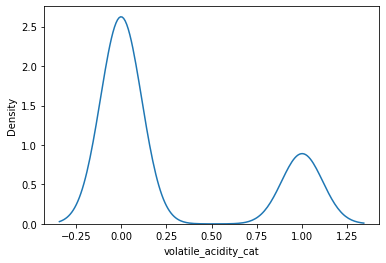

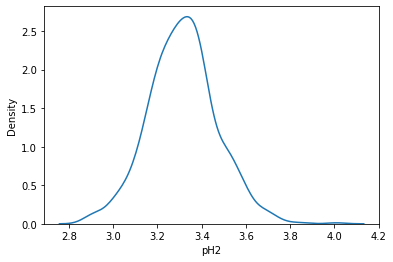

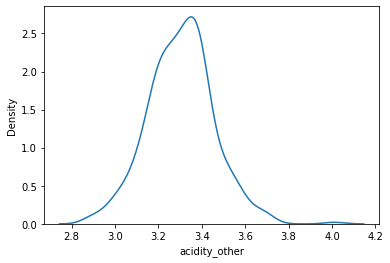

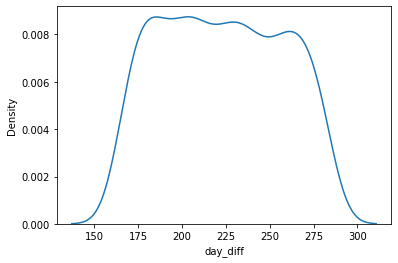

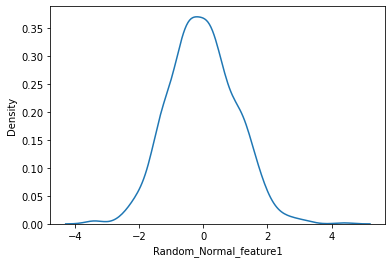

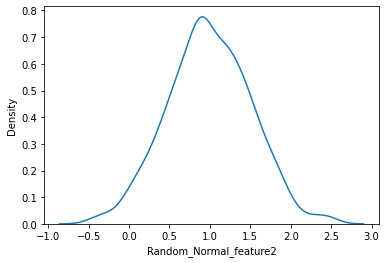

In [45]:
# Let's see the features distributions in order to see if we have strange / extrem values
continuous_feature_analyze_distribution = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality',
       'fixed_acidity_cat', 'volatile_acidity_cat', 'pH2', 'acidity_other', 'day_diff',
       'Random_Normal_feature1', 'Random_Normal_feature2']


for i, col in enumerate(train[continuous_feature_analyze_distribution]):
  plt.figure(i)
  sns.kdeplot(x=col, data=train)

In [46]:
# fixed acidity has no strange / extrem values
# volatile acidity has no strange / extrem values
# citric acidity has no strange / extrem values | The min=0 be careful with the plot
# residual sugar has extrem values -> we can do a censure at 10
# chlorides has extrem values -> we can do a censure at 0.3
# free sulfur dioxide has extrem values -> we can do a censure at 60
# total sulfur dioxide has extrem values -> we can do a censure at 200
# sulphates has extrem values -> we can do a censure at 1.5

In [47]:
def postitive_censure(database, feature_to_censure, value_censure):
  feature = np.where(database[feature_to_censure] >= value_censure, value_censure, database[feature_to_censure])
  return feature

train['residual sugar'] = postitive_censure(train, 'residual sugar', 10)
train['chlorides'] = postitive_censure(train, 'chlorides', 0.3)
train['free sulfur dioxide'] = postitive_censure(train, 'free sulfur dioxide', 60)
train['total sulfur dioxide'] = postitive_censure(train, 'total sulfur dioxide', 200)
train['sulphates'] = postitive_censure(train, 'sulphates', 1.5)

In [48]:
# We know that we have missing values, let's treat them
train.isna().sum() # They are for pH2 & acidity_other

# There are several ways to treat missing values for numerical features:
# Imputation by the median (or other numerical form) or by an impossible value
# Imputation by the median (or other numerical form) and create a binary feature

# For a categorical feature:
# - You can impute by a category named 'Missing'
# - Sometimes, a missing value has a real world meaning so you can impute it by what it means

# Let's do the second method.
# I suppose a correlation between 'fixed acidity' and pH2 of -0.69

# First, let's create a dummy feature if the value is missing
# train['pH2_missing'] = np.where(train['pH2'].isna(), 1, 0)
# Transform it in a function:
def create_dummy_if_missing(database, feature_with_missings):
  feature = np.where(database[feature_with_missings].isna(), 1, 0)
  return feature

train['pH2_missing'] = create_dummy_if_missing(train, 'pH2')
train['acidity_other_missing'] = create_dummy_if_missing(train, 'acidity_other')

In [49]:
# This line will impute for all the train, let's change it to a function
# train.loc[train['pH2'].isna(), "pH2"] = train.loc[train['pH2'].isna(), "fixed acidity"]*-0.69

def impute_multiply_value(database, feature_to_impute, feature_reference, coef):
  database.loc[database[feature_to_impute].isna(), feature_to_impute] = database.loc[database[feature_to_impute].isna(), feature_reference]*coef

impute_multiply_value(train, 'pH2', 'fixed acidity', -0.69)
# Note that I used fixed acidity, but a deeper correlation analysis would help you to find what suits the best

# For acidity_other, we will impute by the median
median_acidity_other = train['acidity_other'].median()

In [50]:
def impute_missing_by_median(database, feature_with_missings, value_to_impute):
  feature = np.where(database[feature_with_missings].isna(), value_to_impute, database[feature_with_missings])
  return feature

train['acidity_other'] = impute_missing_by_median(train, 'acidity_other', median_acidity_other)

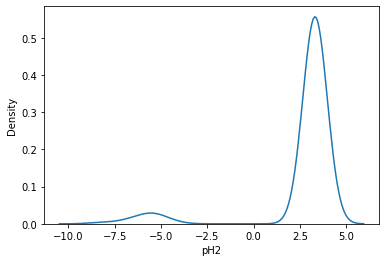

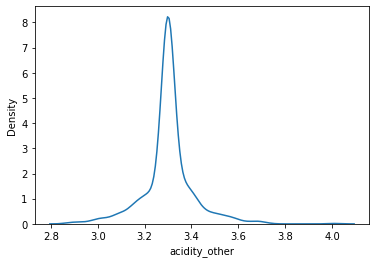

In [51]:
# Now let's check if the 2 distributions changed between before and after the imputation
continuous_feature_analyze_distribution_after_imputation = ['pH2', 'acidity_other']


for i, col in enumerate(train[continuous_feature_analyze_distribution_after_imputation]):
  plt.figure(i)
  sns.kdeplot(x=col, data=train)

In [52]:
# pH2 shoud be between 2.8 & 4
train['pH2'] = postitive_censure(train, 'pH2', 4)

def negative_censure(database, feature_to_censure, value_censure):
  feature = np.where(database[feature_to_censure] <= value_censure, value_censure, database[feature_to_censure])
  return feature

train['pH2'] = negative_censure(train, 'pH2', 2.8)

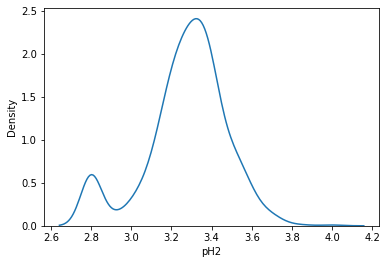

In [53]:
sns.kdeplot(x='pH2', data=train)

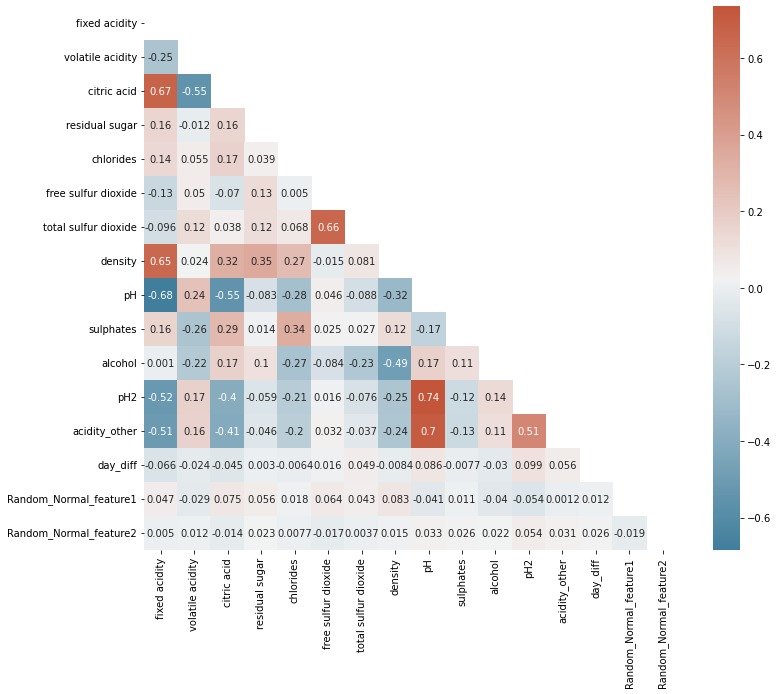

In [54]:
# Now let's analyze the correlations between the quantitative features
# Keep in mind that binary features are not quantitative !!!
feature_analyze_correlation = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'pH2', 'acidity_other',
       'day_diff', 'Random_Normal_feature1',
       'Random_Normal_feature2']

# Get all the correlations:
corr = train[feature_analyze_correlation].corr()
#
# Set up the matplotlib plot configuration
fig, ax = plt.subplots(figsize=(12, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# We can see on the heatmap that we don't have a features having a high correlation (>0.8)
# As a result we can keep them all

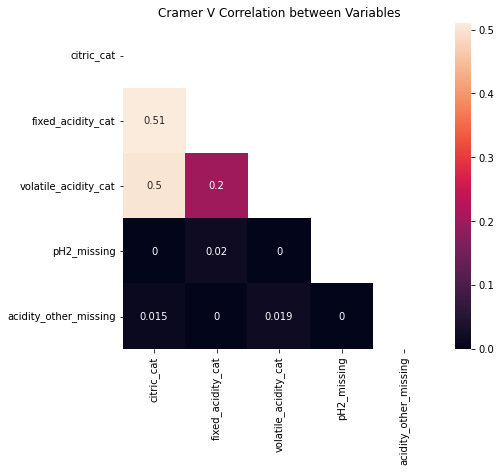

In [55]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cat_feature_analyze_correlation = ['citric_cat', 'fixed_acidity_cat', 'volatile_acidity_cat', 'pH2_missing', 'acidity_other_missing']
corrM = np.zeros((len(cat_feature_analyze_correlation),len(cat_feature_analyze_correlation)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cat_feature_analyze_correlation, 2):
    idx1, idx2 = cat_feature_analyze_correlation.index(col1), cat_feature_analyze_correlation.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(train[col1], train[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr_cramV = pd.DataFrame(corrM, index=cat_feature_analyze_correlation, columns=cat_feature_analyze_correlation)
mask = np.triu(np.ones_like(corr_cramV, dtype=bool))

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr_cramV, annot=True, ax=ax, mask=mask)
ax.set_title("Cramer V Correlation between Variables")
plt.show()

# Same here, we don't have highly correletaed features so we can keep them.

In [56]:
 # Now we can do some feature engineering in order to build new features based on some others.
# This step is only based on domain knowledge & creativity.
# Here I will just create 3 features

def acidity_total(database):
  feature = database['fixed acidity'] + database['volatile acidity']
  return feature

def ratio_density_alcohol(database):
  feature = database['density'] / database['alcohol']
  return feature

def ratio_acidity_pH(database):
  feature = database['acidity_tot'] / database['pH']
  return feature

train['acidity_tot'] = acidity_total(train)
train['ratio_density_alcohol'] = ratio_density_alcohol(train)
train['ratio_acidity_pH'] = ratio_acidity_pH(train)

In [57]:
# Now we have to manage the categorical features in order to transform them in numerical
# An algorithm is just a mathematical process. As a result, it deals only with numerical values

# Most common: One Hot Encoding & used
# Most smart: Target Encoding
# Not to use (except in some very particular cases): Label Encoding

def one_hot_encoding(database, columns_to_OHE):
  database = pd.get_dummies(database, columns = columns_to_OHE)
  return database

train = one_hot_encoding(train, ['citric_cat'])

In [58]:
train.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Y,fixed_acidity_cat,volatile_acidity_cat,pH2,acidity_other,date,time_diff,day_diff,Random_Normal_feature1,Random_Normal_feature2,pH2_missing,acidity_other_missing,acidity_tot,ratio_density_alcohol,ratio_acidity_pH,citric_cat_A,citric_cat_B,citric_cat_Z
1612,9.2,0.430,0.52,2.3,0.083,14.0,23.0,0.99760,3.35,0.61,11.3,6,0,1,0,3.35,3.35,2021-01-27 01:01:50,257 days 22:58:10,257.957060,1.088694,0.742170,0,0,9.630,0.088283,2.874627,0,0,1
378,11.4,0.625,0.66,6.2,0.088,6.0,24.0,0.99880,3.11,0.99,13.3,6,0,1,0,3.11,3.11,2021-04-26 12:52:20,168 days 11:07:40,168.463657,0.722033,1.219221,0,0,12.025,0.075098,3.866559,0,0,1
1436,10.0,0.380,0.38,1.6,0.169,27.0,90.0,0.99914,3.15,0.65,8.5,5,0,1,1,3.15,3.15,2021-04-18 07:59:55,176 days 16:00:05,176.666725,0.238554,0.737487,0,0,10.380,0.117546,3.295238,0,0,1


In [59]:
# Let's define the feature we will use for X & Y
X_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'fixed_acidity_cat',
       'volatile_acidity_cat', 'pH2', 'acidity_other',
       'day_diff', 'Random_Normal_feature1', 'Random_Normal_feature2',
       'pH2_missing', 'acidity_other_missing', 'acidity_tot',
       'ratio_density_alcohol', 'ratio_acidity_pH', 'citric_cat_A',
       'citric_cat_B', 'citric_cat_Z']

Y_feature = ['Y']

In [60]:
print('Number of observations=1: ' + str(train.Y.sum()))
print('\nPercentage of observations=1: ' + str(train.Y.mean()*100))

Number of observations=1: 127

Percentage of observations=1: 15.319662243667068


In [61]:
# Based on this percentage we need to rebalance our data set in order to increase the percentage at least until 30%
# Easiest method: oversampling having the objective to add (to copy) the positive labels
# Second method is undersampling having the objective to delete some negative labels
# Best method based on machine learning: SMOTE -> A little bit better than the previous one but more complex. 
# Let's try the smote for this session

In [62]:
sm = SMOTE(random_state=893717398, sampling_strategy=0.55)
xTrain, yTrain = sm.fit_resample(train[X_features], train[Y_feature])

# Now let's transform the data in array to a dataframe
train_smote = pd.concat([xTrain, yTrain], axis=1)
train_smote = train_smote.sample(n=len(train_smote), random_state=893717398)

In [63]:
# -> Important: At this step you can still have a lot of features. It is necessary to select the best one
# We will try it even if 26 features is not that much.
# We will do this method 2 times, a first one in order to test a linear modeling.
# A second one in order to test a non-linear modeling

In [64]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rf_feat_selec = RandomForestClassifier(bootstrap=True, # resampling of the database for each tree
                                       class_weight=None, #we already resampled before with SMOTE
                                       criterion='gini', #gini or entropy, not very important
                                       max_depth=5, #take a number between 5&8 depending of the size of the database
                                       max_features='auto', #number of featuer selected by tree
                                       max_leaf_nodes=None, #not important to change
                                       min_samples_leaf=30, #Because we have a small database, 150 is good
                                       n_estimators=500, #Number of trees
                                       n_jobs=-1, #We take all the processors -1 that we have
                                       random_state=893717398)

rfecv_feat_selec = RFECV(estimator=rf_feat_selec,
                         step=1,
                         cv=3,
                         scoring='roc_auc',
                         n_jobs=-1)

rfecv_feat_selec.fit(xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

RFECV(cv=3,
      estimator=RandomForestClassifier(max_depth=5, min_samples_leaf=30,
                                       n_estimators=500, n_jobs=-1,
                                       random_state=893717398),
      n_jobs=-1, scoring='roc_auc')

25
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


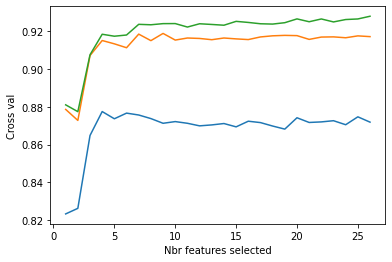

In [65]:
print(rfecv_feat_selec.n_features_)
print(rfecv_feat_selec.support_)

plt.figure()
plt.xlabel('Nbr features selected')
plt.ylabel('Cross val')
plt.plot(range(1, len(rfecv_feat_selec.grid_scores_)+1), rfecv_feat_selec.grid_scores_)
plt.show()

In [66]:
n_features=10

rfe_feat_selec = RFE(estimator=rf_feat_selec, 
                     step=1,
                     n_features_to_select=n_features)
rfe_feat_selec.fit(xTrain, yTrain)

selected_X = pd.DataFrame(xTrain, columns=X_features).columns[rfe_feat_selec.get_support(indices=True)]

del(xTrain, yTrain) # I delete them in order to make easy by keeping a dataframe instead of an array

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expe

In [67]:
# Get the final list of features and add the target
final_list_features = selected_X.append(pd.Index(['Y']))
final_list_features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'total sulfur dioxide', 'density', 'sulphates', 'alcohol',
       'ratio_density_alcohol', 'citric_cat_A', 'Y'],
      dtype='object')

In [68]:
# Now apply all of the cleaning work we did on the test and temporal dataset.


In [71]:
# Let's apply all the treatments that we did on the test & oot datasets.
# You can see the reason why we created a lot of functions -> it is much more
# efficient to use.

# I put a lot of comments because unfortunatly several treatments are not useful
# for the final features selected. As a result, it is useless to make it run by the server.

test = drop_duplicate_keep_first(test, feature_analyze_duplicates)
oot = drop_duplicate_keep_first(oot, feature_analyze_duplicates)

#test['residual sugar'] = postitive_censure(test, 'residual sugar', 10)
#oot['residual sugar'] = postitive_censure(oot, 'residual sugar', 10)

test['chlorides'] = postitive_censure(test, 'chlorides', 0.3)
oot['chlorides'] = postitive_censure(oot, 'chlorides', 0.3)

#test['free sulfur dioxide'] = postitive_censure(test, 'free sulfur dioxide', 60)
#oot['free sulfur dioxide'] = postitive_censure(oot, 'free sulfur dioxide', 60)

test['total sulfur dioxide'] = postitive_censure(test, 'total sulfur dioxide', 200)
oot['total sulfur dioxide'] = postitive_censure(oot, 'total sulfur dioxide', 200)

test['sulphates'] = postitive_censure(test, 'sulphates', 1.5)
oot['sulphates'] = postitive_censure(oot, 'sulphates', 1.5)

#test['pH2_missing'] = create_dummy_if_missing(test, 'pH2')
#oot['pH2_missing'] = create_dummy_if_missing(oot, 'pH2')

#test['acidity_other_missing'] = create_dummy_if_missing(test, 'acidity_other')
#oot['acidity_other_missing'] = create_dummy_if_missing(oot, 'acidity_other')

#impute_multiply_value(test, 'pH2', 'fixed acidity', -0.69)
#impute_multiply_value(oot, 'pH2', 'fixed acidity', -0.69)

#test['acidity_other'] = impute_missing_by_median(test, 'acidity_other', median_acidity_other)
#oot['acidity_other'] = impute_missing_by_median(oot, 'acidity_other', median_acidity_other)

#test['pH2'] = postitive_censure(test, 'pH2', 4)
#oot['pH2'] = postitive_censure(oot, 'pH2', 4)

#test['pH2'] = negative_censure(test, 'pH2', 2.8)
#oot['pH2'] = negative_censure(oot, 'pH2', 2.8)

#test['acidity_tot'] = acidity_total(test)
#oot['acidity_tot'] = acidity_total(oot)

test['ratio_density_alcohol'] = ratio_density_alcohol(test)
oot['ratio_density_alcohol'] = ratio_density_alcohol(oot)

#test['ratio_acidity_pH'] = ratio_acidity_pH(test)
#oot['ratio_acidity_pH'] = ratio_acidity_pH(oot)

test = one_hot_encoding(test, ['citric_cat'])
oot = one_hot_encoding(oot, ['citric_cat'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [73]:
# Modelling


In [74]:
#Logistic Regression

In [76]:
import statsmodels.api as stms
# Be careful with the dummy features because the logistic regression is sensitive
# to the full rank column condition

logit_model = stms.Logit(train_smote['Y'], train_smote[final_list_features].iloc[:,0:-1])
result_logit = logit_model.fit()

print(result_logit.summary2())

Optimization terminated successfully.
         Current function value: 0.380655
         Iterations 9
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.415      
Dependent Variable:    Y                   AIC:                 848.3042   
Date:                  2021-12-09 14:51    BIC:                 898.2252   
No. Observations:      1088                Log-Likelihood:      -414.15    
Df Model:              9                   LL-Null:             -707.59    
Df Residuals:          1078                LLR p-value:         1.3770e-120
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        9.0000                                              
---------------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|    [0.025    0.975] 
---------------------------------------------------------------------------
fixed acidity    

In [77]:
# Here we can see that LLR p-value:1.3770e-120 -> It is <0.05 so the overall model is significant to predict the quality
# However, volatile acidity, citric acid and alcohol have a P>|z| <0.05 -> they are not significant in the model

# We need to delete them. 
# BE CAREFUL! You have to delete them on an iterative way from the one having the highest pvalue to the one having the lowest.

logit_model = stms.Logit(train_smote['Y'], train_smote[['volatile acidity', 
                                                       'citric acid', 'chlorides',
                                                       'total sulfur dioxide', 'density', 
                                                       'sulphates', 'alcohol',
                                                       'ratio_density_alcohol', 
                                                       'citric_cat_A']])
result_logit = logit_model.fit()

print(result_logit.summary2())

Optimization terminated successfully.
         Current function value: 0.380655
         Iterations 9
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.415      
Dependent Variable:    Y                   AIC:                 846.3047   
Date:                  2021-12-09 14:54    BIC:                 891.2336   
No. Observations:      1088                Log-Likelihood:      -414.15    
Df Model:              8                   LL-Null:             -707.59    
Df Residuals:          1079                LLR p-value:         1.5561e-121
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        9.0000                                              
---------------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|    [0.025    0.975] 
---------------------------------------------------------------------------
volatile acidity 

In [78]:
logit_model = stms.Logit(train_smote['Y'], train_smote[['volatile acidity', 
                                                       'citric acid', 'chlorides',
                                                       'total sulfur dioxide', 'density', 
                                                       'sulphates',
                                                       'ratio_density_alcohol', 
                                                       'citric_cat_A']])
result_logit = logit_model.fit()

print(result_logit.summary2())

Optimization terminated successfully.
         Current function value: 0.382209
         Iterations 7
                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.412      
Dependent Variable:     Y                   AIC:                 847.6873   
Date:                   2021-12-09 14:55    BIC:                 887.6240   
No. Observations:       1088                Log-Likelihood:      -415.84    
Df Model:               7                   LL-Null:             -707.59    
Df Residuals:           1080                LLR p-value:         8.7570e-122
Converged:              1.0000              Scale:               1.0000     
No. Iterations:         7.0000                                              
----------------------------------------------------------------------------
                        Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
----------------------------------------------------------------------------
volat

In [79]:
logit_model = stms.Logit(train_smote['Y'], train_smote[['volatile acidity', 
                                                       'chlorides',
                                                       'total sulfur dioxide', 'density', 
                                                       'sulphates',
                                                       'ratio_density_alcohol', 
                                                       'citric_cat_A']])
result_logit = logit_model.fit()

print(result_logit.summary2())

Optimization terminated successfully.
         Current function value: 0.383476
         Iterations 7
                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.410      
Dependent Variable:     Y                   AIC:                 848.4443   
Date:                   2021-12-09 14:56    BIC:                 883.3890   
No. Observations:       1088                Log-Likelihood:      -417.22    
Df Model:               6                   LL-Null:             -707.59    
Df Residuals:           1081                LLR p-value:         3.3438e-122
Converged:              1.0000              Scale:               1.0000     
No. Iterations:         7.0000                                              
----------------------------------------------------------------------------
                        Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
----------------------------------------------------------------------------
volat

In [80]:
# Here, everything seems to work well.
# However, there is a coefficient who takes all the information.
# We know that it is equals to density / alcohol -> let's delete it and add alcohol again


logit_model = stms.Logit(train_smote['Y'], train_smote[['volatile acidity', 
                                                       'chlorides',
                                                       'total sulfur dioxide', 'density', 
                                                       'sulphates', 'alcohol',
                                                        
                                                       'citric_cat_A']])
result_logit = logit_model.fit()

print(result_logit.summary2())

Optimization terminated successfully.
         Current function value: 0.386310
         Iterations 7
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.406      
Dependent Variable:   Y                  AIC:                854.6103   
Date:                 2021-12-09 14:57   BIC:                889.5549   
No. Observations:     1088               Log-Likelihood:     -420.31    
Df Model:             6                  LL-Null:            -707.59    
Df Residuals:         1081               LLR p-value:        7.1436e-121
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       7.0000                                            
------------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
------------------------------------------------------------------------
volatile acidity      -1.8730   0.6938  -2.6997 0.0

In [81]:
# Now the coefficients are more homogeneous and the AIC/BIC have almost the same values as before
# So we can keep this modeling.

# Now, let's predict them on the test & oot

test = pd.concat([test, pd.Series(result_logit.predict(test[['volatile acidity', 'chlorides','total sulfur dioxide', 
                           'density', 'sulphates', 'alcohol', 'citric_cat_A']]), name='Predict_statsmodels')], axis=1)

oot = pd.concat([oot, pd.Series(result_logit.predict(oot[['volatile acidity', 'chlorides','total sulfur dioxide', 
                           'density', 'sulphates', 'alcohol', 'citric_cat_A']]), name='Predict_statsmodels')], axis=1)

In [82]:
def confusion_matrix(dataset, true_label, predicted_probas, number_to_consider):
  pos = np.ones(number_to_consider,)
  neg = np.zeros(dataset.shape[0] - number_to_consider,)
  dataset = dataset.sort_values(by=predicted_probas, ascending=False)
  dataset['Label_predicted_statsmodels'] = np.concatenate((pos, neg), axis=0)
  del(pos, neg, number_to_consider)
  output = pd.crosstab(dataset['Label_predicted_statsmodels'], dataset[true_label])
  print('\nTarget rate: '+ str(np.round(dataset[true_label].sum()/len(dataset), 2)))
  print('\nPrecision: ' + str(np.round((output[1][1])/(output[0][1]+output[1][1]), 2)))
  print('\nRecall: ' + str(np.round((output[1][1])/(output[1][0]+output[1][1]), 2)))
  return output

In [83]:
confusion_matrix(test, 'Y', 'Predict_statsmodels',33)



Target rate: 0.11

Precision: 0.48

Recall: 0.5


Y,0,1
Label_predicted_statsmodels,,
0.0,238,16
1.0,17,16


In [84]:
confusion_matrix(oot, 'Y', 'Predict_statsmodels', 111)



Target rate: 0.12

Precision: 0.44

Recall: 0.73


Y,0,1
Label_predicted_statsmodels,,
0.0,427,18
1.0,62,49


In [85]:
#Logistic Regressions with SKLearn| Ridge & Lasso
from sklearn.linear_model import LogisticRegression

lr_skl = LogisticRegression(random_state=893717398, max_iter=300).fit(train_smote[['volatile acidity', 
                                                       'chlorides', 'total sulfur dioxide', 
                                                       'density', 'sulphates', 
                                                       'alcohol', 'citric_cat_A']], 
                                                        train_smote['Y'])

# Here I added .reset_index() in order to avoid some mismatch with the predict
test.reset_index(inplace=True)
oot.reset_index(inplace=True)

# Given the fact we use sklearn the prediction is a 2D array, so I add [:,1] in order 
# to keep only the probability of 1 in order to suit the confusion_matrix function
test = pd.concat([test, pd.Series(lr_skl.predict_proba(test[['volatile acidity', 
                                                             'chlorides', 
                                                             'total sulfur dioxide', 
                                                             'density', 'sulphates', 
                                                             'alcohol', 'citric_cat_A']])[:,1], 
                                  name='Predict_sklearn_reglog_ridge')], axis=1)

oot = pd.concat([oot, pd.Series(lr_skl.predict_proba(oot[['volatile acidity', 
                                                             'chlorides', 
                                                             'total sulfur dioxide', 
                                                             'density', 'sulphates', 
                                                             'alcohol', 'citric_cat_A']])[:,1], 
                                  name='Predict_sklearn_reglog_ridge')], axis=1)

In [86]:
confusion_matrix(test, 'Y', 'Predict_sklearn_reglog_ridge',33)



Target rate: 0.11

Precision: 0.45

Recall: 0.47


Y,0,1
Label_predicted_statsmodels,,
0.0,237,17
1.0,18,15


In [87]:
confusion_matrix(oot, 'Y', 'Predict_sklearn_reglog_ridge', 111)



Target rate: 0.12

Precision: 0.41

Recall: 0.67


Y,0,1
Label_predicted_statsmodels,,
0.0,423,22
1.0,66,45


In [88]:
# On this first test it appears that the Ridge regression is less powerful than the logistic one.
lr_skl_lasso = LogisticRegression(random_state=893717398, 
                                  max_iter=300, 
                                  penalty='l1',
                                  solver='liblinear').fit(train_smote[['volatile acidity', 
                                                       'chlorides', 'total sulfur dioxide', 
                                                       'density', 'sulphates', 
                                                       'alcohol', 'citric_cat_A']], 
                                                        train_smote['Y'])

test = pd.concat([test, pd.Series(lr_skl_lasso.predict_proba(test[['volatile acidity', 
                                                             'chlorides', 
                                                             'total sulfur dioxide', 
                                                             'density', 'sulphates', 
                                                             'alcohol', 'citric_cat_A']])[:,1], 
                                  name='Predict_sklearn_reglog_lasso')], axis=1)

oot = pd.concat([oot, pd.Series(lr_skl_lasso.predict_proba(oot[['volatile acidity', 
                                                             'chlorides', 
                                                             'total sulfur dioxide', 
                                                             'density', 'sulphates', 
                                                             'alcohol', 'citric_cat_A']])[:,1], 
                                  name='Predict_sklearn_reglog_lasso')], axis=1)

In [89]:
confusion_matrix(test, 'Y', 'Predict_sklearn_reglog_lasso',33)



Target rate: 0.11

Precision: 0.48

Recall: 0.5


Y,0,1
Label_predicted_statsmodels,,
0.0,238,16
1.0,17,16


In [90]:
confusion_matrix(oot, 'Y', 'Predict_sklearn_reglog_lasso', 111)



Target rate: 0.12

Precision: 0.43

Recall: 0.72


Y,0,1
Label_predicted_statsmodels,,
0.0,426,19
1.0,63,48
